# 6.2 Preparing the dataset
I am using the UCI Sentiment Labelled Sentences dataset instead of the UCI SMS Spam Collection dataset to get some novel results.

In [1]:
# Prepare to download the dataset
# import requests
# import zipfile
# import os
# from pathlib import Path
# url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
# zip_path = "sms_spam_collection.zip"
# extracted_path = "sms_spam_collection"
# data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

In [2]:
# A function for downloading the dataset
# def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
#     if data_file_path.exists():
#         print(f"{data_file_path} already exists. Skipping download and extraction.")
#         return
#     response = requests.get(url, stream=True, timeout=60)
#     response.raise_for_status()
#     with open(zip_path, "wb") as out_file:
#         for chunk in response.iter_content(chunk_size=8192):
#             if chunk:
#                 out_file.write(chunk)
#     with zipfile.ZipFile(zip_path, "r") as zip_ref:
#         zip_ref.extractall(extracted_path)
#     original_file_path = Path(extracted_path) / "SMSSpamCollection"
#     os.rename(original_file_path, data_file_path)
#     print(f"File downloaded and saved as {data_file_path}")

# try:
#     download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
# except (requests.exceptions.RequestException, TimeoutError) as e:
#     print(f"Primary URL failed: {e}. Trying backup URL...")
#     url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
#     download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

In [3]:
# Run the function
# download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

In [4]:
# Read the data
# import pandas as pd
# df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
# df

In [5]:
# Examine the class label distribution
# print(df["Label"].value_counts())

In [6]:
# A function for creating a balanced dataset
# def create_balanced_dataset(df):
#     num_spam = df[df["Label"] == "spam"].shape[0]
#     ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
#     balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
#     return balanced_df

In [7]:
# # Create a balanced dataset and convert class labels
# balanced_df = create_balanced_dataset(df)
# print(balanced_df["Label"].value_counts())

In [8]:
# Map the label
# balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})
# balanced_df

In [9]:
# Import the sentiment dataset
import pandas as pd
data = []
with open("sentiment_combined.txt", "r", encoding="utf-8") as f:
    for line in f:
        line = line.rstrip('\n')
        text, label = line.rsplit('\t', 1)
        data.append((text, label))
balanced_df = pd.DataFrame(data, columns=["Text", "Label"])
balanced_df

,Text,Label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
2995,The screen does get smudged easily because it ...,0
2996,What a piece of junk.. I lose more calls on th...,0
2997,Item Does Not Match Picture.,0
2998,The only thing that disappoint me is the infra...,0


In [10]:
# A function for splitting the dataset
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac = 1, random_state = 123).reset_index(drop = True)
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    return train_df, validation_df, test_df

In [11]:
# Split the dataset and save the parts to CSV
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
train_df.to_csv("train.csv", index = None)
validation_df.to_csv("validation.csv", index = None)
test_df.to_csv("test.csv", index = None)

# 6.3 Creating data loaders

In [12]:
# Load the tokenizer and add special padding token
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special = {"<|endoftext|>"}))

[50256]


In [13]:
# Setting up a PyTorch Dataset class
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            self.encoded_texts = [encoded_text[:self.max_length] for encoded_text in self.encoded_texts]
        self.encoded_texts = [encoded_text + [pad_token_id] * (self.max_length - len(encoded_text)) for encoded_text in self.encoded_texts]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.long))

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [14]:
# Load the train data with the SpamDataset class
train_dataset = SpamDataset(csv_file="train.csv", max_length=None, tokenizer=tokenizer)
print(train_dataset.max_length)

103


In [15]:
# Load the validation and test set
val_dataset = SpamDataset(csv_file = "validation.csv", max_length = train_dataset.max_length, tokenizer = tokenizer)
test_dataset = SpamDataset(csv_file = "test.csv", max_length = train_dataset.max_length, tokenizer = tokenizer)

## Exercise 6.1 - Page 179
This exercise can be done through adding the following lines in the next code chunk. Since it takes too long to train on my laptop, I decided not to finish this exercise. According to the exercise solutions, this adjustment results in a substantially worse test accuracy.

In [ ]:
# Exercise 6.1
# max_length = 1024
# train_dataset = SpamDataset("train.csv", max_length=max_length, tokenizer=tokenizer)
# val_dataset = SpamDataset("validation.csv", max_length=max_length, tokenizer=tokenizer)
# test_dataset = SpamDataset("test.csv", max_length=max_length, tokenizer=tokenizer)

In [16]:
# Creating PyTorch data loaders
from torch.utils.data import DataLoader
num_workers = 0
batch_size = 8
torch.manual_seed(123)
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True,
                          num_workers = num_workers, drop_last = True)
val_loader = DataLoader(dataset = val_dataset, batch_size = batch_size,
                        num_workers = num_workers, drop_last = False)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size,
                        num_workers = num_workers, drop_last = False)

In [17]:
# Print the tensor dimensions
for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions:", target_batch.shape)

Input batch dimensions: torch.Size([8, 103])
Label batch dimensions: torch.Size([8])


In [18]:
# Print the total number of batches in each dataset
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

262 training batches
38 validation batches
75 test batches


# 6.4 Initializing a model with pretrained weights

In [19]:
# Employ the same configurations as before
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "So far, I had"
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [20]:
# Loading a pretrained GPT model
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size = model_size, models_dir = "../chapter-5-learn/gpt2")
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

2025-10-10 15:32:17.933460: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


File already exists and is up-to-date: ../chapter-5-learn/gpt2/124M/checkpoint
File already exists and is up-to-date: ../chapter-5-learn/gpt2/124M/encoder.json
File already exists and is up-to-date: ../chapter-5-learn/gpt2/124M/hparams.json
File already exists and is up-to-date: ../chapter-5-learn/gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: ../chapter-5-learn/gpt2/124M/model.ckpt.index
File already exists and is up-to-date: ../chapter-5-learn/gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: ../chapter-5-learn/gpt2/124M/vocab.bpe


In [21]:
# Ensure the model generates coherent text
from previous_chapters import generate_text_simple, text_to_token_ids, token_ids_to_text
text_1 = "So far, I had"
token_ids = generate_text_simple(model = model, idx = text_to_token_ids(text_1, tokenizer), 
                                 max_new_tokens = 15, context_size = BASE_CONFIG["context_length"])
print(token_ids_to_text(token_ids, tokenizer))

So far, I had no idea what to expect.

I was so excited to see the


In [22]:
# Test model classifying capabilities
text_2 = ("Is the following text 'spam'? Answer with 'yes' or 'no': "
"'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'")
token_ids = generate_text_simple(model=model, idx=text_to_token_ids(text_2, tokenizer),
                                 max_new_tokens=23, context_size=BASE_CONFIG["context_length"])
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


# 6.5 Adding a classification head

In [23]:
# Print the model architecture
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [24]:
# Freeze the model
for param in model.parameters():
    param.requires_grad = False

In [25]:
# Adding a classification layer
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(in_features = BASE_CONFIG["emb_dim"], out_features = num_classes)

In [26]:
# Making the final LayerNorm and last transformer block trainable
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

## Exercise 6.2 - Page 186
This exercise can be done through removing the following lines in the next code chunk. Since it takes too long to train on my laptop, I decided not to finish this exercise. According to the exercise solutions, this adjustment results in a bit improvements in test accuracy.

In [ ]:
# Exercise 6.2
# for param in model.parameters():
#     param.requires_grad = False

In [27]:
# Feed the model an example text
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [28]:
# Pass the encoded token IDs to the model as usual
with torch.no_grad():
    outputs = model(inputs)
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [29]:
# Extract the last output token
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


## Exercise 6.3 - Page 190
This exercise can be done through changing `model(input_batch)[:, -1, :]` to `model(input_batch)[:, 0, :]` everywhere in the code. Since it takes too long to train on my laptop, I decided not to finish this exercise. According to the exercise solutions, this adjustment results in a substantially worse test accuracy.

# 6.6 Calculating the classification loss and accuracy

In [30]:
# Obtain the class label
probas = torch.softmax(outputs[:, -1, :], dim = -1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


In [31]:
# Simplify the code without using softmax
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


In [32]:
# Calculating the classification accuracy
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
            predicted_labels = torch.argmax(logits, dim=-1)
            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [33]:
# Try the above function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches = 10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches = 10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches = 10)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 38.75%
Validation accuracy: 48.75%
Test accuracy: 52.50%


In [34]:
# Define the loss function
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :] # optimizing only the last token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [35]:
# Calculating the classification loss
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [36]:
# Compute the initial losses
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.437
Validation loss: 2.704
Test loss: 2.314


# 6.7 Fine-tuning the model on supervised data

In [37]:
# Function for model evaluation (same as the one in chapter 5)
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [38]:
# Fine-tuning the model to classify spam
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [39]:
# Initialize the optimizer, set the number of epochs, and initiate training
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.017, Val loss 2.505
Ep 1 (Step 000050): Train loss 0.726, Val loss 0.710
Ep 1 (Step 000100): Train loss 0.700, Val loss 0.728
Ep 1 (Step 000150): Train loss 0.706, Val loss 0.703
Ep 1 (Step 000200): Train loss 0.700, Val loss 0.710
Ep 1 (Step 000250): Train loss 0.697, Val loss 0.703
Training accuracy: 50.00% | Validation accuracy: 47.50%
Ep 2 (Step 000300): Train loss 0.708, Val loss 0.728
Ep 2 (Step 000350): Train loss 0.684, Val loss 0.704
Ep 2 (Step 000400): Train loss 0.679, Val loss 0.697
Ep 2 (Step 000450): Train loss 0.668, Val loss 0.665
Ep 2 (Step 000500): Train loss 0.705, Val loss 0.629
Training accuracy: 67.50% | Validation accuracy: 72.50%
Ep 3 (Step 000550): Train loss 0.649, Val loss 0.600
Ep 3 (Step 000600): Train loss 0.510, Val loss 0.582
Ep 3 (Step 000650): Train loss 0.566, Val loss 0.613
Ep 3 (Step 000700): Train loss 0.464, Val loss 0.535
Ep 3 (Step 000750): Train loss 0.446, Val loss 0.507
Training accuracy: 80.00% | Validation a

In [50]:
# A function for plotting (similar to the one in Chapter 5)
import matplotlib.pyplot as plt
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()
    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples seen")
    fig.tight_layout()
    plt.show()

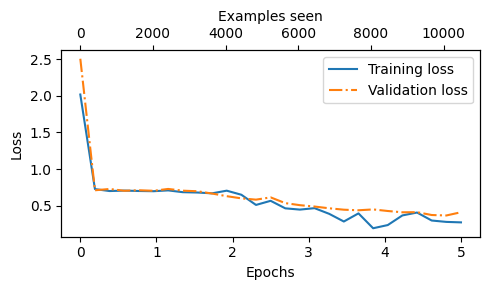

In [51]:
# Plot the loss function for the training and validation set
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

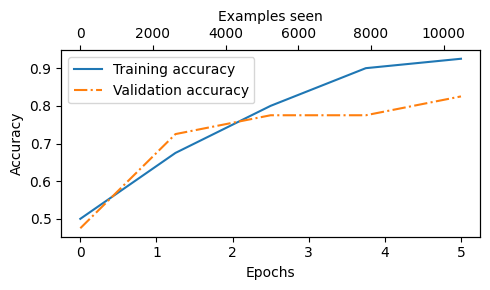

In [52]:
# Plot the classification accuracies
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [56]:
# Calculate the accuracy for training, validation, and test sets across the entire dataset
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 90.94%
Validation accuracy: 85.33%
Test accuracy: 89.50%


# 6.8 Using the LLM as a spam (sentiment) classifier

In [46]:
# Using the model to classify new texts
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    input_ids = input_ids[:min(max_length, supported_context_length)]
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()
    return "positive" if predicted_label == 1 else "negative"

In [47]:
# Try the function on an example text
text_1 = "Amazing experience! The food was flavorful, portions generous, and the staff went above and beyond. Will definitely come back."
print(classify_review(text_1, model, tokenizer, device, max_length=train_dataset.max_length))

positive


In [48]:
# Try the function on another example text
text_2 = "Terrible experience. Food was cold, order was wrong, and staff were rude. Won’t return."
print(classify_review(text_2, model, tokenizer, device, max_length=train_dataset.max_length))

negative


In [55]:
# Save the model
# torch.save(model.state_dict(), "review_classifier.pth")
# model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
# model.load_state_dict(model_state_dict)